In [629]:
from sklearn import svm, datasets 
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_blobs
from sklearn.metrics import confusion_matrix, fbeta_score, make_scorer, average_precision_score, auc, \
    accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, classification_report, \
    brier_score_loss


from sklearn.calibration import CalibratedClassifierCV, calibration_curve

import pylab as plt
import numpy as np
from scipy.stats import randint as sp_randint , uniform
import pandas as pd

from sklearn.metrics import precision_recall_curve, roc_curve
import matplotlib.pyplot as plt
from inspect import signature
from sklearn import datasets

In [597]:
def plot_pr_mat(df,y_test):
  
  for n in df.index:
  
    y_score=df.loc[n,'y_score']
#     y_test=df.loc[n,'y_test']
    name=df.loc[n,'model']
    
  
    average_precision = average_precision_score(y_test, y_score)
    precision, recall, _ = precision_recall_curve(y_test, y_score)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision,  alpha=0.5,
             where='post', label ='{0:}  AP={1:0.2f}'.format(name,average_precision))
    # plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve')
    plt.legend()
    
def plot_roc_mat(y_test,df):

  for n in df.index:
  
    y_score=df.loc[n,'y_score']
    name=df.loc[n,'model'] 
    
    fpr, tpr, thresholds = roc_curve(y_test,  y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=1, label='%s (AUC = %0.2f)' % (name,roc_auc));





  plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
           label='Chance', alpha=.8)
  plt.xlim([-0.05, 1.05])
  plt.ylim([-0.05, 1.05])
  plt.xlabel('FPR = FP/(FP+TN)')
  plt.ylabel('TPR = Recall = (TP/(TP+FN)) ')
  plt.title('ROC viewed')
  plt.legend(loc="lower right");
  plt.axis('square');

In [589]:
def add_metrics(y_test,y_score,y_pred,model,df=None):
  # records the scores in a DataFrame
  
  average_precision = average_precision_score(y_test, y_score)

  cm=confusion_matrix(y_test, y_pred)
  tn, fp, fn, tp =cm.ravel()

  df2=pd.DataFrame([[model,tn, fp, fn, tp,average_precision,y_score,y_pred,y_test]],
                   columns=['model','tn', 'fp', 'fn', 'tp','AP','y_score','y_pred','y_test'])
  if df is None:
    df=df2
  else:
    df=pd.concat((df,df2),ignore_index=True)
  return(df)
  

In [598]:
def confusion_matrix_threshold(y_test,y_prob,levels=200,normalize_all=False,normalize_class=True):
    
    thresholds=np.linspace(0,1,levels)
    tp=0*thresholds
    tn=0*thresholds
    fp=0*thresholds
    fn=0*thresholds

    n=0
    for threshold in thresholds:
        y_pred_threshold=y_prob > threshold 
        tp[n]=np.sum( y_test & y_pred_threshold)
        tn[n]=np.sum( ~y_test & ~y_pred_threshold)
        fp[n]=np.sum( ~y_test & y_pred_threshold)
        fn[n]=np.sum( y_test & ~y_pred_threshold)

        n+=1
        
    if normalize_all:
        n=y_test.shape[0]
        return(tn/n, fp/n, fn/n, tp/n,thresholds )
    elif normalize_class:
        npos=np.sum(y_test)
        nn=y_test.shape[0]-npos
        
        return(tn/nn, fp/nn, fn/npos, tp/npos,thresholds )
    else:
        return(tn, fp, fn, tp,thresholds )
    
def plot_prob_cal(df,bins=10):

    fig = plt.figure(1, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    for n in df.index:

        prob_pos=df.loc[n,'y_score']
        name=df.loc[n,'model']
        y_test=df.loc[n,'y_test']

        prob_pos =   (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=bins)
        brier_score = brier_score_loss(y_test, prob_pos, pos_label=1)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s  (%1.3f)" % (name,brier_score ))

        ax2.hist(prob_pos, range=(0, 1), bins=bins, label=name,
             histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

# Dataset:  two unbalcanced clusters difficult to separate 

We intentionally create a dataset that is very difficult to separate because:
* the classes overlap strongly
* the class split is 95% - 5 %

In [353]:
random_state=0

# two clusters of random points with unbalanced classes
class_ratio=0.05

n_samples_1 = 2000
n_samples_2 = int(class_ratio*n_samples_1)

std_1=0.8
std_2=0.4

centers = [[0.0, 0.0], [1.0, 1.0]]
clusters_std = [std_1, std_2]
X, y = make_blobs(n_samples=[n_samples_1, n_samples_2],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state=0, shuffle=False)

X_train, X_test, y_train, y_test = train_test_split(X , y ,test_size=.5,
                                                    random_state=random_state)

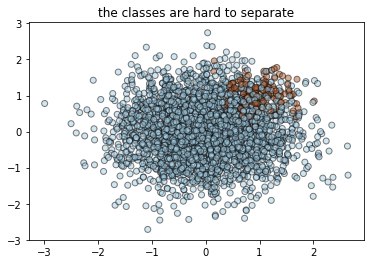

In [319]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, edgecolors='k',alpha=0.5);
plt.title('the classes are hard to separate');


Class 0 is illustrated by the many blue dots, class 1 by the few red dots.

This problem is inherently very challenging. The most important choices we need to do are:
* choosing the tradeoff of misclassification (e.g. is it important to detect most of class 1 items at the expense of several false detections?) 
* choosing the classifier. In this case a linear classifier will fare worse that a non linear classifier

We intentionally neglect that the classes are unbalanced and we fit a LogisticRegression classifier.

In [151]:
lrclf = LogisticRegression(random_state=0, solver='lbfgs',C=1,penalty='l2')
lrclf.fit(X_train, y_train)

y_score = lrclf.predict_proba(X_test)[:,1]
y_pred = lrclf.predict(X_test)

df=add_metrics(y_test,y_score,y_pred,'LR')

In [44]:
print("accuracy_score: ",accuracy_score(y_test,y_pred))
print("balanced_accuracy_score: ",balanced_accuracy_score(y_test,y_pred))

print()
print(classification_report(y_test,y_pred))

accuracy_score:  0.9504761904761905
balanced_accuracy_score:  0.5575099800399201

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1002
           1       0.38      0.12      0.19        48

    accuracy                           0.95      1050
   macro avg       0.67      0.56      0.58      1050
weighted avg       0.93      0.95      0.94      1050



In [59]:
print('Confusion Matrix')
print('C true,predicted')
print()
cm=confusion_matrix(y_test, y_pred)
print(cm)
print()
tn, fp, fn, tp =cm.ravel()

print('true negatives  : true 0, predicted 0: ',tn)
print('false positives : true 0, predicted 1: ',fp)
print('false negatives : true 1, predicted 0: ',fn)
print('true positives  : true 1, predicted 1: ',tp)


Confusion Matrix
C true,predicted

[[992  10]
 [ 42   6]]

true negatives  : true 0, predicted 0:  992
false positives : true 0, predicted 1:  10
false negatives : true 1, predicted 0:  42
true positives  : true 1, predicted 1:  6


The confusion matrix shows that:
* we miss to detect only 10 negatives on 1002
* we miss 42 positives on 48

Accuracy was high as it is defined as (TP+TN)/population.

In [62]:
print("precision_score: ",precision_score(y_test,y_pred))
print("recall_score: ",recall_score(y_test,y_pred))


precision_score:  0.375
recall_score:  0.125
0.375


Precision is: TP/predicted positive  = 6/16

$ P= TP/(TP+FP)$

Recall is: TP/real positive = 6/48

$ R= TP/(TP+FN)$



In [61]:
fpr, tpr, thresholds = roc_curve(y_test,  y_score)
roc_auc = auc(fpr, tpr)
print("auc_score: ",roc_auc)


auc_score:  0.9428642714570858


The standard accuracy score is high (0.95) but misleading. In fact, class 0 is predicted well, but class 1 is predicted poorly. In many situations (e.g. fraud detection, failure detection), the unfrequent class is the critical one to detect.

Balanced accuracy, or macro averaged accuracy (avg across the labels) are better indicators.



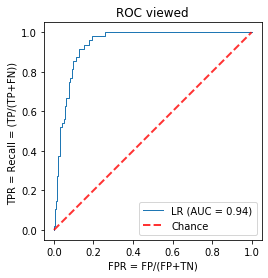

In [68]:
plot_roc_mat(y_test,df)

The AUC is also misleading in case of unbalanced classes. The curve starts with very low recall and it's necessary to accept a false positive rate of 10% to have a recall of 60% 

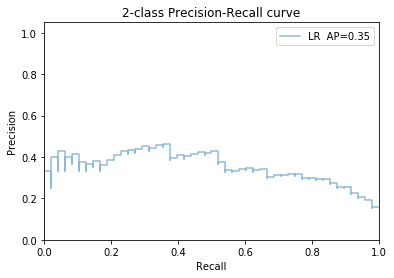

In [69]:
plot_pr_mat(y_test,df)

The same information can be visualized from the Precision-Recall curve that shows that even tuning the threshold (typically 0.5) of the decision between 0 and 1 the precision is limited.

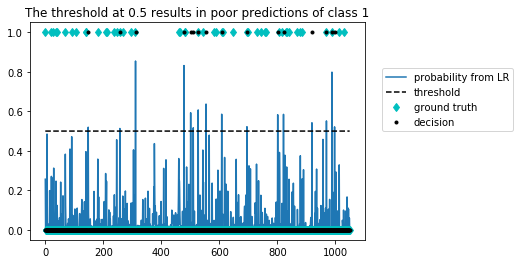

In [72]:
plt.plot(y_score,label='probability from LR')
plt.plot(0.5+0*y_score,'k--',label='threshold')
plt.plot(y_test,'cd',label='ground truth')
plt.plot(y_pred,'k.',label='decision')
plt.legend(loc=(1.05,0.5))
plt.title('The threshold at 0.5 results in poor predictions of class 1');


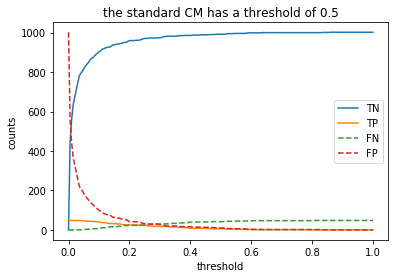

In [152]:
tn, fp, fn, tp,t=confusion_matrix_threshold(y_test,y_score,levels=200,normalize_class=False);
plt.plot(t,tn,'-',label='TN');
plt.plot(t,tp,'-',label='TP');
plt.plot(t,fn,'--',label='FN');
plt.plot(t,fp,'--',label='FP');
plt.legend()
plt.xlabel('threshold')
plt.ylabel('counts');
plt.title('the standard CM has a threshold of 0.5');


Lowering the threshold to increase TP, leads to a dramatic increase of FP

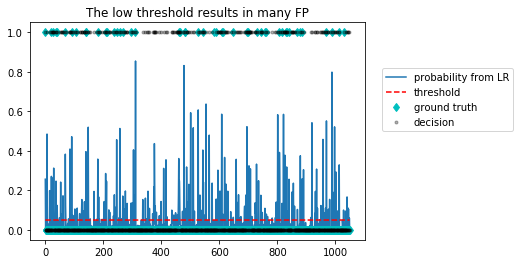

In [136]:
threshold=0.05

plt.plot(y_score,label='probability from LR')
plt.plot(threshold+0*y_score,'r--',label='threshold')
plt.plot(y_test,'cd',label='ground truth')

y_pred_t=y_score>threshold
plt.plot(y_pred_t,'k.',label='decision',alpha=0.3)
plt.legend(loc=(1.05,0.5))
plt.title('The low threshold results in many FP');


## Accounting for umbalanced classes

Simply setting class_weight='balanced' weights more the underrepresented classes

In [153]:
lrclfb = LogisticRegression(random_state=0, solver='lbfgs',C=1,penalty='l2',class_weight='balanced')
lrclfb.fit(X_train, y_train)

y_score = lrclfb.predict_proba(X_test)[:,1]
y_pred = lrclfb.predict(X_test)

df=add_metrics(y_test,y_score,y_pred,'LRb',df)

In [138]:
print("accuracy_score: ",accuracy_score(y_test,y_pred))
print("balanced_accuracy_score: ",balanced_accuracy_score(y_test,y_pred))

print()
print(classification_report(y_test,y_pred))

accuracy_score:  0.8457142857142858
balanced_accuracy_score:  0.8894086826347305

              precision    recall  f1-score   support

           0       1.00      0.84      0.91      1002
           1       0.22      0.94      0.36        48

    accuracy                           0.85      1050
   macro avg       0.61      0.89      0.63      1050
weighted avg       0.96      0.85      0.89      1050



In [139]:
print('Confusion Matrix')
print('C true,predicted')
print()
cm=confusion_matrix(y_test, y_pred)
print(cm)
print()
tn, fp, fn, tp =cm.ravel()

print('true negatives  : true 0, predicted 0: ',tn)
print('false positives : true 0, predicted 1: ',fp)
print('false negatives : true 1, predicted 0: ',fn)
print('true positives  : true 1, predicted 1: ',tp)


Confusion Matrix
C true,predicted

[[843 159]
 [  3  45]]

true negatives  : true 0, predicted 0:  843
false positives : true 0, predicted 1:  159
false negatives : true 1, predicted 0:  3
true positives  : true 1, predicted 1:  45


The false positives increased 16x but we identified almost all the positives (except 3).

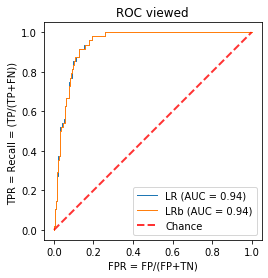

In [140]:
plot_roc_mat(y_test,df)

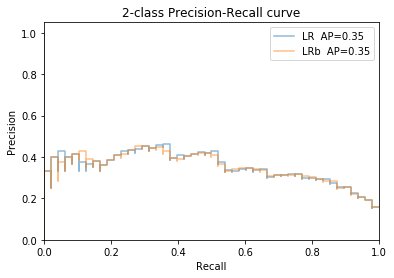

In [141]:
plot_pr_mat(y_test,df)

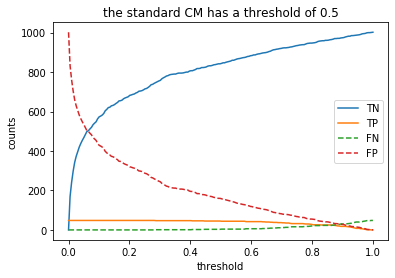

In [154]:
tn, fp, fn, tp,t=confusion_matrix_threshold(y_test,y_score,levels=200,normalize_class=False);
plt.plot(t,tn,'-',label='TN');
plt.plot(t,tp,'-',label='TP');
plt.plot(t,fn,'--',label='FN');
plt.plot(t,fp,'--',label='FP');
plt.legend()
plt.xlabel('threshold')
plt.ylabel('counts');
plt.title('the standard CM has a threshold of 0.5');

In [157]:
# the tradeoff can be adjusted with the probability threshold used
fp[tp==40]

array([103., 101.,  98.])

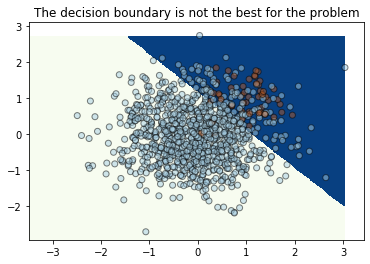

In [183]:
x_min, x_max = X_test[:, 0].min() - .5, X_test[:, 0].max() + .5
y_min, y_max = X_test[:, 1].min() - .5, X_test[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = lrclfb.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.GnBu);

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, edgecolors='k',alpha=0.5);
plt.title('The decision boundary is not the best for the problem');

# Choice of classifier

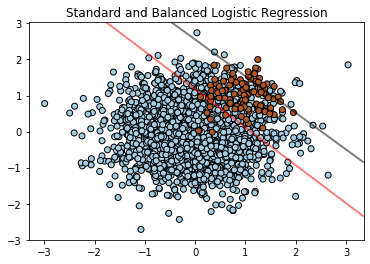

In [197]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

Z = lrclf.decision_function(xy).reshape(XX.shape)
a = ax.contour(XX, YY, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'],linewidths=2)

Z = lrclfb.decision_function(xy).reshape(XX.shape)
a = ax.contour(XX, YY, Z, colors='r', levels=[0], alpha=0.5, linestyles=['-'],linewidths=2)
plt.title('Standard and Balanced Logistic Regression');

The picture above shows why adjusting the decision threshold can help a bit but has limits due to the problem and the linear separation boundary typical of LogisticRegression

In [220]:
wclf = svm.SVC(C=1,kernel='rbf' ,random_state=0, class_weight="balanced",gamma="scale",probability=True)
wclf.fit(X_train,y_train)

y_score = wclf.predict_proba(X_test)[:,1]
y_pred = wclf.predict(X_test)

df=add_metrics(y_test,y_score,y_pred,'SVCr',df)

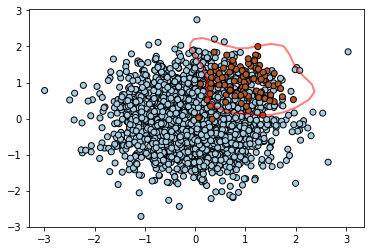

In [354]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

Z = wclf.decision_function(xy).reshape(XX.shape)
a = ax.contour(XX, YY, Z, colors='r', levels=[0], alpha=0.5, linestyles=['-'],linewidths=2)


In [221]:
print("accuracy_score: ",accuracy_score(y_test,y_pred))
print("balanced_accuracy_score: ",balanced_accuracy_score(y_test,y_pred))

print()
print(classification_report(y_test,y_pred))

accuracy_score:  0.8895238095238095
balanced_accuracy_score:  0.9024451097804391

              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1002
           1       0.28      0.92      0.43        48

    accuracy                           0.89      1050
   macro avg       0.64      0.90      0.69      1050
weighted avg       0.96      0.89      0.92      1050



In [222]:
print('Confusion Matrix')
print('C true,predicted')
print()
cm=confusion_matrix(y_test, y_pred)
print(cm)
print()
tn, fp, fn, tp =cm.ravel()

print('true negatives  : true 0, predicted 0: ',tn)
print('false positives : true 0, predicted 1: ',fp)
print('false negatives : true 1, predicted 0: ',fn)
print('true positives  : true 1, predicted 1: ',tp)


Confusion Matrix
C true,predicted

[[890 112]
 [  4  44]]

true negatives  : true 0, predicted 0:  890
false positives : true 0, predicted 1:  112
false negatives : true 1, predicted 0:  4
true positives  : true 1, predicted 1:  44


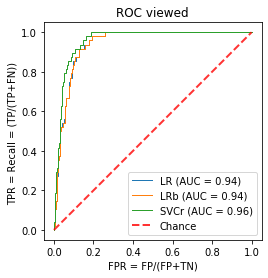

In [223]:
plot_roc_mat(y_test,df)

The support vector machine model with radial basis functions achieves significanlty better recall at the same False Positive Rate 

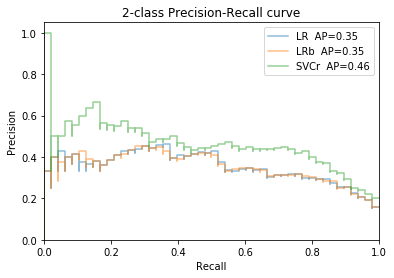

In [224]:
plot_pr_mat(y_test,df)

This is also evident from the Precision Recall curve and the average precision metric.

The calibration of the classifiers is reasonable given the task. It does not show over or underconfindence (transposed sigmoid or sigmoid shapes)

In [14]:
def cm_score(y_test,y_pred,c_fn,c_fp):
  
  cm=confusion_matrix(y_test, y_pred)
  tn, fp, fn, tp =cm.ravel()
  score=-c_fn*fn - c_fp*fp
  return(score)

scoring = make_scorer(cm_score, c_fn=100, c_fp=2, greater_is_better=True)

In [306]:
scoring='average_precision'
# scoring='balanced_accuracy'
# scoring='f1_weighted'
# scoring='roc_auc'

## Radial basis function SVC

In [360]:
wclf = svm.SVC(C=1,kernel='rbf' ,random_state=0, class_weight="balanced",gamma="scale")

param_dist = {
             # "class_weight": {1, uniform(1,20)} ,
              "C": uniform(0.01,100),
            }

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(wclf, scoring=scoring, param_distributions=param_dist,  cv=5, iid=False)

random_search.fit(X_train, y_train)

sorted(random_search.cv_results_.keys())
display(random_search.cv_results_['mean_test_score'])
wclf=random_search.best_estimator_

y_score = wclf.decision_function(X_test)
y_pred = wclf.predict(X_test)


df=add_metrics(y_test,y_score,y_pred,'wrSVC',df=None)


array([0.44173483, 0.43694451, 0.44687141, 0.50447607, 0.4153338 ,
       0.4589989 , 0.44939478, 0.51134826, 0.44916128, 0.42860666])

In [358]:
df

,model,tn,fp,fn,tp,AP,y_score,y_pred
0,wrSVC,894,108,4,44,0.3806,"[1.0910805654017386, -2.168990701264785, -7.71...","[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Linear SVC

In [322]:
lclf = svm.SVC(C=1,kernel='linear' ,random_state=0, class_weight="balanced",gamma="scale")

param_dist = {
             # "class_weight": {1, uniform(1,20)} ,
              "C": uniform(0.01,100),
            }

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(lclf, scoring=scoring, param_distributions=param_dist,  cv=5, iid=False)

random_search.fit(X_train, y_train)

sorted(random_search.cv_results_.keys())
display(random_search.cv_results_['mean_test_score'])
lclf=random_search.best_estimator_

y_score = lclf.decision_function(X_test)
y_pred = lclf.predict(X_test)


df=add_metrics(y_test,y_score,y_pred,'lSVC',df)


array([0.41888356, 0.41897415, 0.41907153, 0.41875169, 0.41875169,
       0.41910602, 0.41907153, 0.41910602, 0.41893966, 0.41907153])

## Decision Tree

In [323]:
param_dist = {
              "max_depth": [3, None],
              "max_features": sp_randint(1, X_train.shape[1]),
              "min_samples_split": sp_randint(2, 20),
            }

# run randomized search
n_iter_search = 20
tclf = DecisionTreeClassifier(  criterion="entropy",class_weight="balanced")
#clf = DecisionTreeClassifier(  criterion="entropy",class_weight={0:1,1:10})
random_search = RandomizedSearchCV(tclf, scoring=scoring, param_distributions=param_dist,  cv=5, iid=False)

random_search.fit(X_train, y_train)

sorted(random_search.cv_results_.keys())
display(random_search.cv_results_['mean_test_score'])
tclf=random_search.best_estimator_

y_score = tclf.predict_proba(X_test)[:,1]
y_pred = tclf.predict(X_test)


df=add_metrics(y_test,y_score,y_pred,'DT',df)

array([0.19772222, 0.27664941, 0.25040357, 0.17285139, 0.28031703,
       0.17960672, 0.2562939 , 0.25461505, 0.26593303, 0.16839512])

## RandomForest

In [324]:
param_dist = {
              "n_estimators": sp_randint(1, 40),
              "max_depth": [3, None],
              "max_features": sp_randint(1, 2),
              #"max_features": uniform(0.1, 1.),
              #"max_features": ["auto","log2"],
              "min_samples_split": sp_randint(2, 20),
            }

# run randomized search
n_iter_search = 20
rfclf = RandomForestClassifier( bootstrap=20, criterion="entropy",class_weight="balanced")
random_search = RandomizedSearchCV(rfclf, scoring=scoring, param_distributions=param_dist,  cv=5, iid=False)

random_search.fit(X_train, y_train)

sorted(random_search.cv_results_.keys())
display(random_search.cv_results_['mean_test_score'])
rfclf=random_search.best_estimator_

y_score = rfclf.predict_proba(X_test)[:,1]
y_pred = rfclf.predict(X_test)


df=add_metrics(y_test,y_score,y_pred,'RF',df)

array([0.45634656, 0.48839789, 0.42039596, 0.38822935, 0.45084835,
       0.40733426, 0.36236627, 0.38276677, 0.45924395, 0.47735325])

In [362]:
df.iloc[:,0:-2]

,model,tn,fp,fn,tp,AP
0,wrSVC,891,111,4,44,0.463345


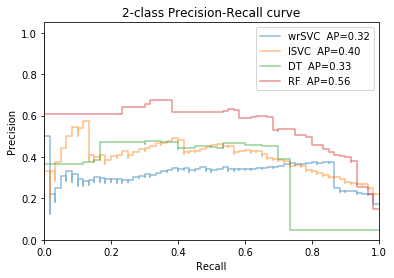

In [326]:
plot_pr_mat(y_test,df)

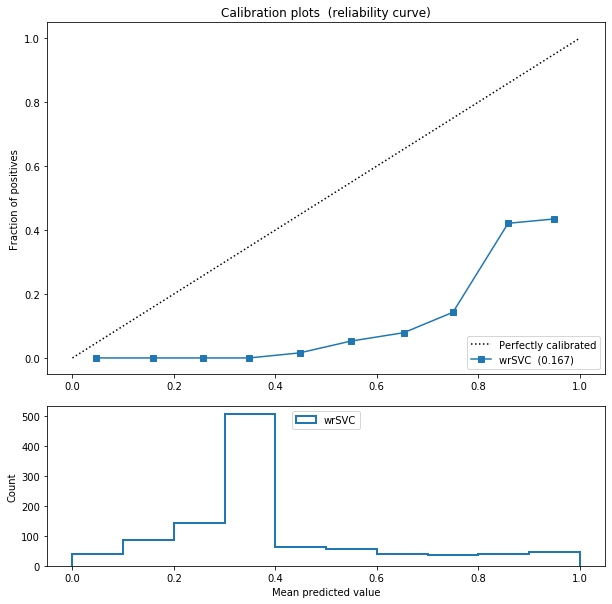

In [361]:
plot_prob_cal(df,y_test)

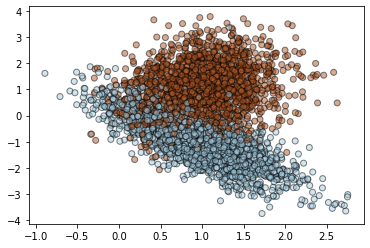

In [636]:


X, y = datasets.make_classification(n_samples=200000,n_features=2,n_clusters_per_class=1, weights=[.5,.5],
                                    n_informative=2, n_redundant=0, class_sep=1,
                                    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.98, random_state=42)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, edgecolors='k',alpha=0.5);

In [637]:
param_dist = {
              "n_estimators": sp_randint(1, 40),
              "max_depth": [3, None],
              "max_features": sp_randint(1, 2),
              #"max_features": uniform(0.1, 1.),
              #"max_features": ["auto","log2"],
              "min_samples_split": sp_randint(2, 20),
            }

# run randomized search
n_iter_search = 5
rfclf = RandomForestClassifier( bootstrap=20, criterion="entropy",class_weight="balanced")
random_search = RandomizedSearchCV(rfclf, scoring=scoring, param_distributions=param_dist,  cv=5, iid=False)

random_search.fit(X_train, y_train)

sorted(random_search.cv_results_.keys())
display(random_search.cv_results_['mean_test_score'])
rfclf=random_search.best_estimator_

y_score = rfclf.predict_proba(X_test)[:,1]
y_pred = rfclf.predict(X_test)


df=add_metrics(y_test,y_score,y_pred,'200k 50-50')

array([0.94664785, 0.89543835, 0.9516761 , 0.95064397, 0.95036359,
       0.95100512, 0.94478129, 0.95166308, 0.95404719, 0.94870758])

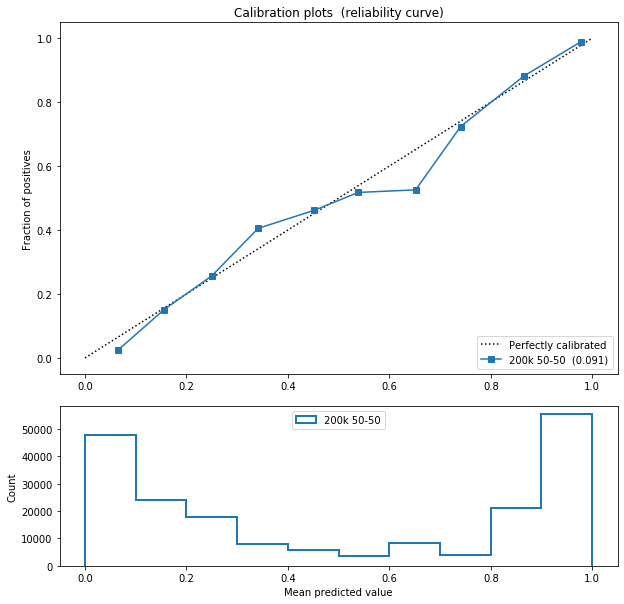

In [639]:
plot_prob_cal(df)

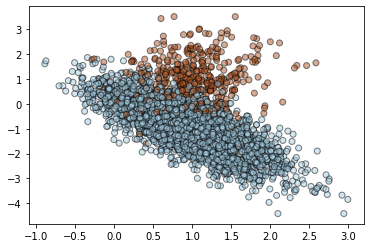

In [640]:
X, y = datasets.make_classification(n_samples=200000,n_features=2,n_clusters_per_class=1, weights=[.9,.1],
                                    n_informative=2, n_redundant=0, class_sep=1,
                                    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.98, random_state=42)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, edgecolors='k',alpha=0.5);

In [641]:
param_dist = {
              "n_estimators": sp_randint(1, 40),
              "max_depth": [3, None],
              "max_features": sp_randint(1, 2),
              #"max_features": uniform(0.1, 1.),
              #"max_features": ["auto","log2"],
              "min_samples_split": sp_randint(2, 20),
            }

# run randomized search
n_iter_search = 5
rfclf = RandomForestClassifier( bootstrap=20, criterion="entropy",class_weight="balanced")
random_search = RandomizedSearchCV(rfclf, scoring=scoring, param_distributions=param_dist,  cv=5, iid=False)

random_search.fit(X_train, y_train)

sorted(random_search.cv_results_.keys())
display(random_search.cv_results_['mean_test_score'])
rfclf=random_search.best_estimator_

y_score = rfclf.predict_proba(X_test)[:,1]
y_pred = rfclf.predict(X_test)


df=add_metrics(y_test,y_score,y_pred,'200k 90-10',df)

array([0.81243541, 0.8036089 , 0.80538381, 0.7277498 , 0.7784181 ,
       0.78751001, 0.80700328, 0.80189704, 0.79690666, 0.76109887])

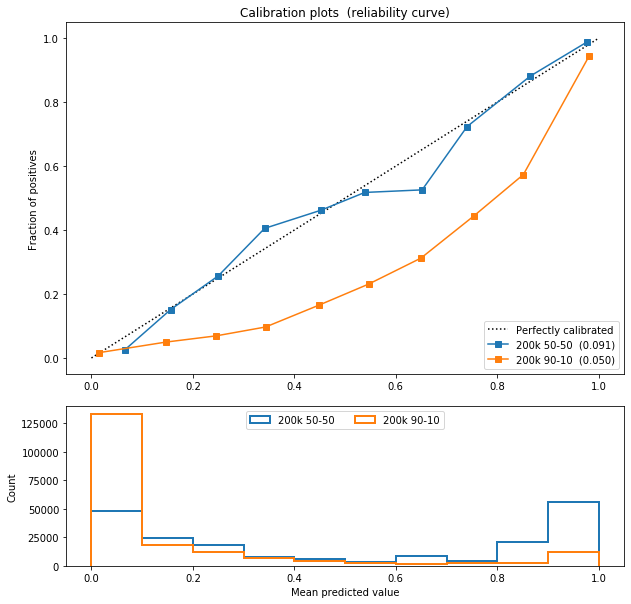

In [642]:
plot_prob_cal(df)

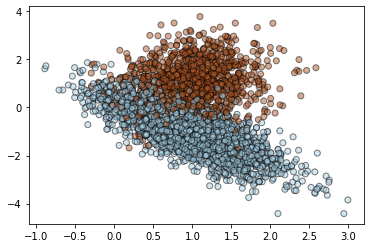

In [662]:
X, y = datasets.make_classification(n_samples=200000,n_features=2,n_clusters_per_class=1, weights=[.7,.4],
                                    n_informative=2, n_redundant=0, class_sep=1,
                                    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.98, random_state=42)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, edgecolors='k',alpha=0.5);

In [663]:
param_dist = {
              "n_estimators": sp_randint(1, 40),
              "max_depth": [3, None],
              "max_features": sp_randint(1, 2),
              #"max_features": uniform(0.1, 1.),
              #"max_features": ["auto","log2"],
              "min_samples_split": sp_randint(2, 20),
            }

# run randomized search
n_iter_search = 5
rfclf = RandomForestClassifier( bootstrap=20, criterion="entropy",class_weight="balanced")
random_search = RandomizedSearchCV(rfclf, scoring=scoring, param_distributions=param_dist,  cv=5, iid=False)

random_search.fit(X_train, y_train)

sorted(random_search.cv_results_.keys())
display(random_search.cv_results_['mean_test_score'])
rfclf=random_search.best_estimator_

y_score = rfclf.predict_proba(X_test)[:,1]
y_pred = rfclf.predict(X_test)


df=add_metrics(y_test,y_score,y_pred,'200k 70-30',df)

array([0.91168879, 0.88775881, 0.91508427, 0.91699853, 0.91387302,
       0.9099096 , 0.9174675 , 0.89809213, 0.90104838, 0.91482751])

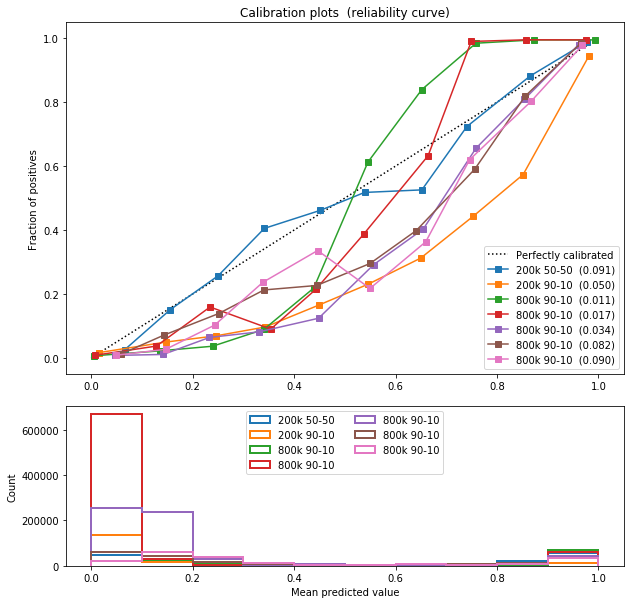

In [664]:
plot_prob_cal(df)